In [1]:
# original version
# https://github.com/marugari/Notebooks/blob/master/LightGBM.ipynb

import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
train = pd.read_csv('/home/tks/data/otto/train.csv')
print(train.shape)

(61878, 95)


In [3]:
def encode_features(dat):
    df = pd.DataFrame(index=dat.index.values)
    for c in dat.columns.values:
        unq = np.unique(dat[c])
        arr = np.zeros(len(df))
        for ii, u in enumerate(unq):
            flg = (dat[c] == u).values
            arr[flg] = ii
        df[c] = arr.astype(int)
    return df

In [4]:
x = encode_features(train.drop(['id', 'target'], axis=1))
y = np.array([int(v.split('_')[1])-1 for v in train.target])
print(x.shape, y.shape)

((61878, 93), (61878,))


In [5]:
num_cls = len(np.unique(y))
print(num_cls)

9


In [6]:
prm_xgb = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': num_cls,
    'max_depth': 5,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'subsample': 0.9,
    'eval_metric': 'mlogloss',
    # added
    'silent': 0,
}
prm_lgb_1 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': num_cls,
    'num_leaves' : 2**5-1,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'metric': 'multi_logloss',
    # added 
    'verbose': 0,
}
prm_lgb_2 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': num_cls,
    'num_leaves' : 2**6, # changed
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'metric': 'multi_logloss',
    # added 
    'max_depth': 6, # not 5
    'bagging_freq': 1,
    'min_data_in_leaf': 1,
    'min_sum_hessian_in_leaf': 1,
    'lambda_l2': 1,
    'verbose': 0,
}
num_round = 100

In [7]:
flg_train = np.random.choice([False, True], len(y), p=[0.3, 0.7])
flg_valid = np.logical_not(flg_train)

In [8]:
dt_xgb   = xgb.DMatrix(x[flg_train], y[flg_train])
dv_xgb   = xgb.DMatrix(x[flg_valid], y[flg_valid])
dt_lgb   = lgb.Dataset(x[flg_train], y[flg_train])
dv_lgb   = lgb.Dataset(x[flg_valid], y[flg_valid], reference=dt_lgb)
dt_lgb_c = lgb.Dataset(x[flg_train], y[flg_train], free_raw_data=False)
dv_lgb_c = lgb.Dataset(x[flg_valid], y[flg_valid], free_raw_data=False,
                       reference=dt_lgb)

In [9]:
scores_xgb = {}
time_s = time.time()
obj_xgb = xgb.train(
    prm_xgb, dt_xgb, num_round,
    [(dt_xgb, 'train'), (dv_xgb, 'valid')], evals_result=scores_xgb, verbose_eval=False)
time_t = time.time()
print(time_t - time_s)

28.4402542114


In [10]:
scores_lgb_1 = {}
time_s = time.time()
obj_lgb_1 = lgb.train(
    prm_lgb_1, dt_lgb, num_boost_round=num_round,
    valid_sets=dv_lgb, evals_result=scores_lgb_1, verbose_eval=False)
time_t = time.time()
print(time_t - time_s)

4.22406983376


In [11]:
scores_lgb_2 = {}
time_s = time.time()
obj_lgb_2 = lgb.train(
    prm_lgb_2, dt_lgb, num_boost_round=num_round,
    valid_sets=dv_lgb, evals_result=scores_lgb_2, verbose_eval=False)
time_t = time.time()
print(time_t - time_s)

3.70146203041


In [12]:
df_score = pd.DataFrame({'XGB':scores_xgb['valid']['mlogloss'],
                         'LGB_orig':scores_lgb_1['valid_0']['multi_logloss'],
                         'LGB_chng':scores_lgb_2['valid_0']['multi_logloss']})
df_score.tail(2)

,LGB_chng,LGB_orig,XGB
98,0.569876,0.521990,0.569543
99,0.568947,0.521132,0.568626


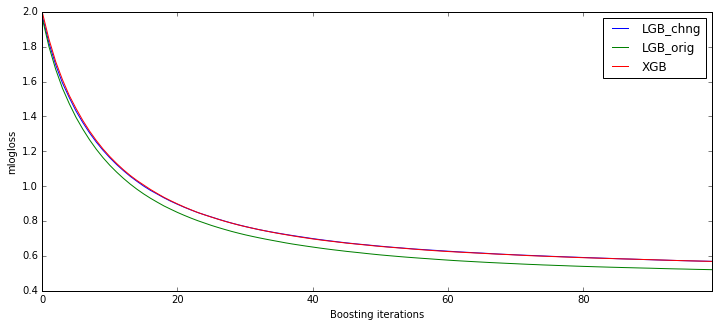

In [13]:
ax = df_score.plot(figsize=(12,5))
ax.set_xlabel("Boosting iterations")
ax.set_ylabel("mlogloss")

In [14]:
dmp = obj_xgb.get_dump()
leaf_cnts_xgb = np.array([tree.count('leaf') for tree in dmp]).reshape((100, 9))

model = obj_lgb_1.dump_model()
tree_lst = [str(tree['tree_structure']) for tree in model['tree_info']]
leaf_cnts_lgb_1 = np.array([tree.count('leaf_value') for tree in tree_lst]).reshape((100, 9))

model = obj_lgb_2.dump_model()
tree_lst = [str(tree['tree_structure']) for tree in model['tree_info']]
leaf_cnts_lgb_2 = np.array([tree.count('leaf_value') for tree in tree_lst]).reshape((100, 9))

In [15]:
leaf_cnts_xgb[-3:]

array([[23, 15, 18, 28, 22, 30, 21, 24, 22],
       [26, 25, 27, 23, 25, 17, 28, 27, 24],
       [13, 31, 31, 25, 13, 17, 23, 24, 18]])

In [16]:
leaf_cnts_lgb_1[-3:]

array([[31, 31, 31, 31, 23, 31, 31, 31, 31],
       [31, 31, 31, 31, 22, 31, 31, 31, 31],
       [31, 31, 31, 31, 21, 31, 31, 31, 31]])

In [17]:
leaf_cnts_lgb_2[-3:]

array([[21, 20, 19, 26, 12, 30, 22, 25, 18],
       [27, 28, 29, 30, 20, 25, 32, 25, 16],
       [19, 25, 26, 28, 20, 24, 23, 22, 26]])

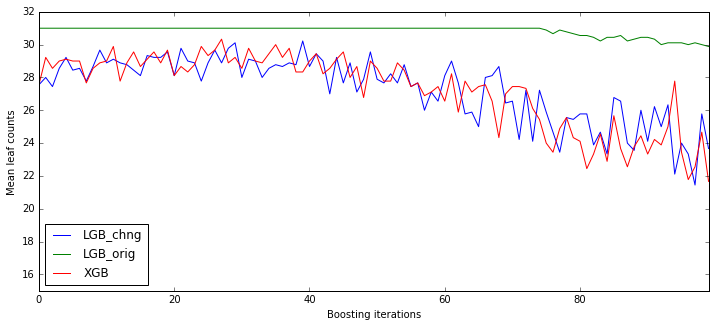

In [18]:
ax = pd.DataFrame({'XGB':leaf_cnts_xgb.mean(1),
                   'LGB_orig':leaf_cnts_lgb_1.mean(1),
                   'LGB_chng':leaf_cnts_lgb_2.mean(1)}).plot(ylim=(15, 32), figsize=(12,5))
ax.set_xlabel("Boosting iterations")
ax.set_ylabel("Mean leaf counts")